# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score 
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [134]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

  past_peak  
0     False  
1     False  
2      True  
3      True  
4      True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [135]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [243]:
#your turn
df_customer1= pd.merge( df_transactions,df_offers, how='left', on=['offer_id'])
df_customer2= df_customer1.iloc[:,(0,1,2)]
df_customer3= pd.pivot_table(df_customer2, values='n', index='customer_name', columns='offer_id')
df_customer4= df_customer3.fillna(value=0)

df_customer4.head()

offer_id        1    2    3    4    5    6    7    8    9    10 ...    23  \
customer_name                                                   ...         
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0 ...   0.0   

offer_id        24   25   26   27   28   29   30   31   32  
customer_name                                               
Adams          0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
Allen          0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Anderson       1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Baker          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 32 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [198]:
# your turn
x_cols= df_customer4.as_matrix()
print(x_cols)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  1.]]


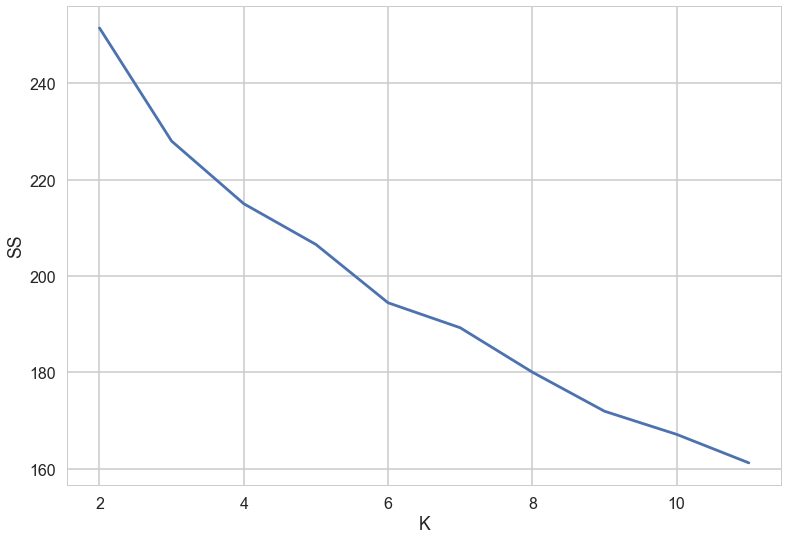

In [133]:
from sklearn.cluster import KMeans
x=[]
SS=[]
for i in range(2,12):
    kmeans= KMeans(n_clusters=i, random_state=1)
    kmeans.fit(x_cols)
    kmeans.transform(x_cols)
    kmeans.labels_
    x.append(i)
    SS.append(kmeans.inertia_)
    
plt.plot(x, SS)
plt.ylabel('SS')
plt.xlabel('K')
plt.show()

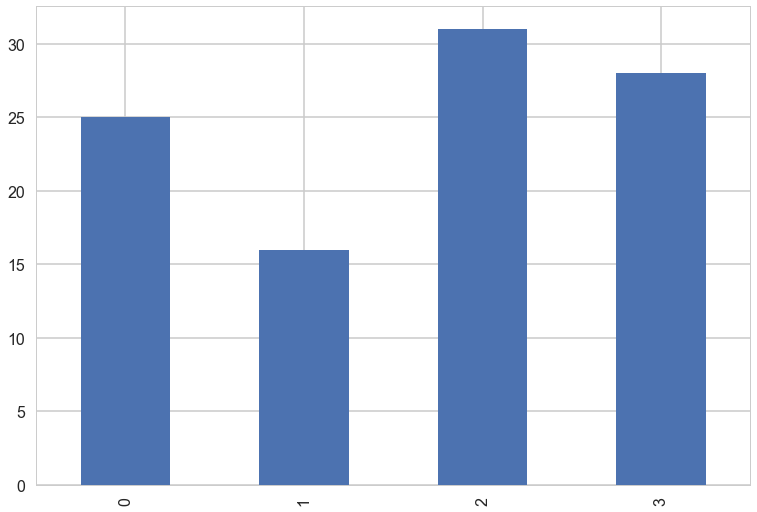

In [155]:
#Best K from the elbow point which is around 4
kmeans= KMeans(n_clusters=4,random_state=1)
kmeans.fit(x_cols)
df_customer4['cluster']=kmeans.predict(x_cols)
df_customer4.cluster.value_counts().sort_index().plot(kind='bar')
plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

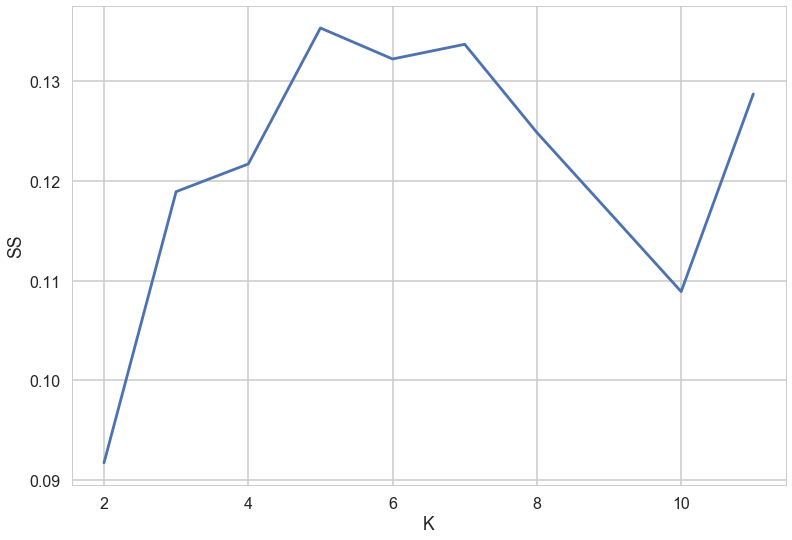

[0.091748715087503513, 0.11889942863638556, 0.12167039851355937, 0.13528618244904822, 0.13218209978013543, 0.13365227784322317, 0.12482407120722075, 0.11686562917000483, 0.10889477148379977, 0.12867792088949781]


In [78]:
# Your turn.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

x1=[]
SS1=[]
for i in range(2,12):
    kmeans= KMeans(n_clusters=i, random_state=1)
    kmeans.fit(x_cols)
    kmeans.transform(x_cols)
    labels=kmeans.labels_
    x1.append(i)
    SS1.append(silhouette_score(x_cols, labels))
    
plt.plot(x1, SS1)
plt.ylabel('SS')
plt.xlabel('K')
plt.show()
print(SS1)

#### Silhouette scores are very low for all the tested K and it looks like there is no substantial structure can be found. However, still K=5 gives the maximum Silhouette score, therefore it is a good choice. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       3
Allen         -0.287539  0.044715       2
Anderson      -0.392032  1.038391       1
Bailey         0.699477 -0.022542       3
Baker          0.088183 -0.471695       0
offer_id         1    2    3    4    5    6    7    8    9   10   ...      24  \
customer_name                                                     ...           
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   ...     0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     1.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   ...     0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   ...     0.0   

offer_id        25   26   27   28   29   30   31   32  cluster  
customer_name                                                   
Adams   

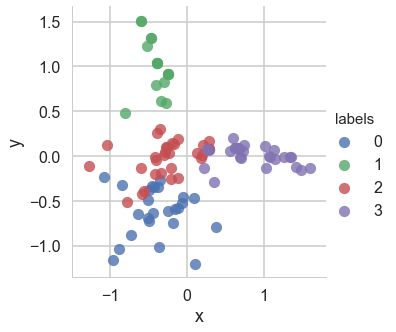

In [231]:
#plot with K=4 and pcs component=2
from sklearn.decomposition import PCA
import seaborn as sns

def pca(cls, n_clus, n_comp, matrix, df_cust):
    df= df_cust.copy()
    pca=PCA(n_components= n_comp, random_state=1) #instantiate PCA
    pca.fit(df) #perform PCA
    data_pca = pd.DataFrame(pca.transform(df)) #get 2 components for PCA
    
    cls_pca = cls(n_clusters=n_clus, random_state=1) #instantiate clustering
    df['cluster']=cls_pca.fit_predict(matrix) #Perform Clustering on the matrix which is x_cols here
    labels=cls_pca.labels_ #get cluster labels from clustering algorithm to put in pca table
    
    data_pca.index = df.index
    data_pca.columns = ['x','y'] #naming two components as x and y
    
    data_pca['labels']= labels #putting labels in the table
    print(data_pca.head())
    if n_clus == 4:
        print(df.head())
    
    sns.lmplot(x='x', y='y', hue='labels', data=data_pca, fit_reg=False) #ploting to see the distribution
    
#plot with K=4
pca(KMeans, 4, 2, x_cols, df_customer4)

                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       3
Allen         -0.287539  0.044715       4
Anderson      -0.392032  1.038391       2
Bailey         0.699477 -0.022542       3
Baker          0.088183 -0.471695       4


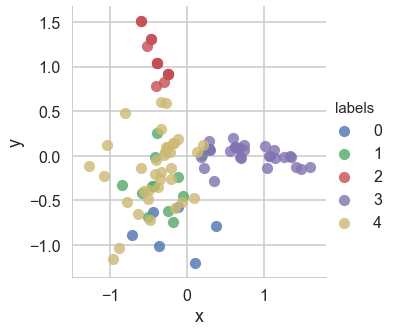

In [222]:
#plot with K=5
pca(KMeans, 5, 2, x_cols, df_customer4)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [225]:
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

  past_peak  
0     False  
1     False  
2      True  
3      True  
4      True

In [226]:
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

In [233]:
data_pca.head()

x         y  labels
customer_name                            
Adams          1.007580  0.108215       3
Allen         -0.287539  0.044715       2
Anderson      -0.392032  1.038391       1
Bailey         0.699477 -0.022542       3
Baker          0.088183 -0.471695       0

In [253]:
data_pca=data_pca.reset_index()
data_pca.head()

customer_name         x         y  labels
0         Adams  1.007580  0.108215       3
1         Allen -0.287539  0.044715       2
2      Anderson -0.392032  1.038391       1
3        Bailey  0.699477 -0.022542       3
4         Baker  0.088183 -0.471695       0

In [244]:
df_customer1=df_customer1.sort(['customer_name'])
df_customer1.head()

/Users/TarjaniAgrawal/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


customer_name  offer_id  n  campaign      varietal  min_qty  discount  \
128         Adams        29  1  November  Pinot Grigio        6        87   
129         Adams        30  1  December        Malbec        6        54   
127         Adams        18  1      July     Espumante        6        50   
102         Allen         9  1     April    Chardonnay      144        57   
103         Allen        27  1   October     Champagne       72        88   

          origin past_peak  
128       France     False  
129       France     False  
127       Oregon     False  
102        Chile     False  
103  New Zealand     False

In [255]:
df_customer0=pd.merge(df_customer1, data_pca, on='customer_name', how='outer')

In [256]:
df_customer0.head()

customer_name  offer_id  n  campaign      varietal  min_qty  discount  \
0         Adams        29  1  November  Pinot Grigio        6        87   
1         Adams        30  1  December        Malbec        6        54   
2         Adams        18  1      July     Espumante        6        50   
3         Allen         9  1     April    Chardonnay      144        57   
4         Allen        27  1   October     Champagne       72        88   

        origin past_peak         x         y  labels  
0       France     False  1.007580  0.108215       3  
1       France     False  1.007580  0.108215       3  
2       Oregon     False  1.007580  0.108215       3  
3        Chile     False -0.287539  0.044715       2  
4  New Zealand     False -0.287539  0.044715       2

In [366]:
#Checking the distribution of each cluster
def clusdist(var):
    df_var=df_customer0[[var, 'labels']]
    df_var=df_var.sort_values(by='labels').reset_index()
    df_var=df_customer0[[var, 'labels']]
    dflbs=df_var.groupby('labels')
    dflbs_0=dflbs.get_group(0).drop_duplicates()
    dflbs_1=dflbs.get_group(1).drop_duplicates()
    dflbs_2=dflbs.get_group(2).drop_duplicates()
    dflbs_3=dflbs.get_group(3).drop_duplicates()
    df_dist= pd.merge(dflbs_0, dflbs_1, on= var, how='outer')
    df_dist= pd.merge(df_dist, dflbs_2, on= var, how='outer')
    df_dist= pd.merge(df_dist, dflbs_3, on= var, how='outer')
    df_dist= df_dist.sort_values(by = var)
    print(df_dist)


In [367]:
var_list = [ 'offer_id', 'campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak']
for var in var_list:
    clusdist(var)


    offer_id  labels_x  labels_y  labels_x  labels_y
9          1       0.0       1.0       2.0       NaN
16         2       0.0       1.0       2.0       NaN
8          3       0.0       NaN       NaN       3.0
10         4       0.0       NaN       2.0       NaN
23         5       0.0       NaN       2.0       NaN
17         6       0.0       NaN       2.0       3.0
0          7       0.0       NaN       NaN       3.0
6          8       0.0       NaN       2.0       3.0
26         9       0.0       NaN       2.0       NaN
1         10       0.0       1.0       2.0       3.0
7         11       0.0       NaN       2.0       NaN
14        12       0.0       1.0       2.0       3.0
31        13       NaN       NaN       NaN       3.0
21        14       0.0       NaN       2.0       NaN
18        15       0.0       NaN       2.0       NaN
29        16       NaN       1.0       2.0       NaN
28        17       NaN       1.0       NaN       NaN
25        18       0.0       NaN       2.0    

### This shows that clusters have not been made on the basis of any one item in the factors. As most of the cluster labels have huge overlap for any item in the selected variable.

### Therefore we now see the count of each item in each cluster.

In [418]:
#Checking the distribution of each cluster
def cluscount(var):
    df_var=df_customer0[[var, 'labels']]
    df_var=df_var.sort_values(by='labels').reset_index()
    df_var=df_customer0[[var, 'labels']]
    dflbs=df_var.groupby('labels')
    
    dflbs_0=dflbs.get_group(0)
    
    #print('GROUP 0: Distribution of ' + var)
    #print(dflbs_0.groupby(var).count())
    dflbs_0 = dflbs_0.groupby(var).count().reset_index()
    #print(dflbs_0)
    
    dflbs_1=dflbs.get_group(1)
    #print('GROUP 1: Distribution of ' + var)
    #print(dflbs_1.groupby(var).count())
    dflbs_1=dflbs_1.groupby(var).count().reset_index()
    #print(dflbs_1)
    
    dflbs_2=dflbs.get_group(2)
    #print('GROUP 2: Distribution of ' + var)
    #print(dflbs_2.groupby(var).count())
    dflbs_2=dflbs_2.groupby(var).count().reset_index()
    #print(dflbs_2)
    
    dflbs_3=dflbs.get_group(3)
    #print('GROUP 3: Distribution of ' + var)
    #print(dflbs_3.groupby(var).count())
    dflbs_3=dflbs_3.groupby(var).count().reset_index()
    #print(dflbs_3)
    
    df_dist= pd.merge(dflbs_0, dflbs_1, on= var, how='outer')
    df_dist= df_dist.rename(columns= {'labels_x' : 'Count_0', 'labels_y' : 'Count_1' })
    df_dist= pd.merge(df_dist, dflbs_2, on= var, how='outer')
    df_dist= pd.merge(df_dist, dflbs_3, on= var, how='outer')
    df_dist= df_dist.rename(columns= {'labels_x' : 'Count_2', 'labels_y' : 'Count_3' })
    print(df_dist)
    
cluscount('varietal')

             varietal  Count_0  Count_1  Count_2  Count_3
0  Cabernet Sauvignon     13.0      NaN       19      NaN
1           Champagne     55.0      1.0       25      NaN
2          Chardonnay      2.0      1.0       12      NaN
3           Espumante     10.0      NaN        5     25.0
4              Malbec      8.0      1.0        7     16.0
5              Merlot      3.0      1.0       10      6.0
6          Pinot Noir      3.0     37.0        4      NaN
7            Prosecco     18.0      2.0        4     19.0
8        Pinot Grigio      NaN      NaN        2     15.0


In [419]:
var_list = [ 'offer_id', 'campaign', 'min_qty', 'discount', 'origin', 'past_peak']
for var in var_list:
    cluscount(var)

    offer_id  Count_0  Count_1  Count_2  Count_3
0          1      4.0      1.0      5.0      NaN
1          2      2.0      6.0      2.0      NaN
2          3      5.0      NaN      NaN      1.0
3          4      7.0      NaN      5.0      NaN
4          5      1.0      NaN      3.0      NaN
5          6      9.0      NaN      2.0      1.0
6          7      4.0      NaN      NaN     15.0
7          8      4.0      NaN      4.0     12.0
8          9      1.0      NaN      9.0      NaN
9         10      3.0      1.0      1.0      2.0
10        11      5.0      NaN      8.0      NaN
11        12      2.0      1.0      1.0      1.0
12        14      3.0      NaN      6.0      NaN
13        15      4.0      NaN      2.0      NaN
14        18      1.0      NaN      1.0     12.0
15        19      4.0      NaN      1.0      NaN
16        20      2.0      NaN      4.0      NaN
17        21      3.0      NaN      1.0      NaN
18        22     20.0      NaN      1.0      NaN
19        23      1.

### Looking at the count of the each item in every cluster does give some insights into the choices that are specific to each cluster. eg
### Cluster 0: prefers Champagne where as Cluster 1: prefers Pinot Noir, however looking at the counts we cant say much about cluster 2 and 3. 
### Cluster 0: purchases in August mostly and Cluster 3: in March. 
### Cluster 3 also likes to purchase min_qty of 6 mostly.
### Cluster 0: likes  Australia made wine more than other clusters


### However, to get more insights it would be better to calculate percentage of preferences by each cluster to get more clear idea.

In [444]:
#Checking the distribution of each cluster
def cluspcnt(var):
    df_var=df_customer0[[var, 'labels']]
    df_var=df_var.sort_values(by='labels').reset_index()
    df_var=df_customer0[[var, 'labels']]
    dflbs=df_var.groupby('labels')
    
    dflbs_0=dflbs.get_group(0)
    #print(dflbs_0)
    #print('GROUP 0: Distribution of ' + var)
    #print(dflbs_0.groupby(var).count())
    
    dflbs_1=dflbs.get_group(1)
    #print(dflbs_1)
    #print('GROUP 1: Distribution of ' + var)
    #print(dflbs_1.groupby(var).count())
    
    dflbs_2=dflbs.get_group(2)
    #print('GROUP 2: Distribution of ' + var)
    #print(dflbs_2.groupby(var).count())
    
    dflbs_3=dflbs.get_group(3)
    #print('GROUP 3: Distribution of ' + var)
    #print(dflbs_3.groupby(var).count())
    #df_dist= pd.merge(dflbs_0, dflbs_1, on= var, how='outer')
    #df_dist= pd.merge(df_dist, dflbs_2, on= var, how='outer')
    #df_dist= pd.merge(df_dist, dflbs_3, on= var, how='outer')
    #df_dist= df_dist.sort_values(by = var)
    
    df_all = dflbs_0.append([dflbs_1,dflbs_2,dflbs_3], ignore_index=True)
    
    df_pcnt_all = df_all.groupby(var).count()

    df_pcnt_all['percentage_0']= (dflbs_0.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all['percentage_1']= (dflbs_1.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all['percentage_2']= (dflbs_2.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all['percentage_3']= (dflbs_3.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all= df_pcnt_all.rename(columns= {'labels' : 'Total_count'})
    print('Percentage distribution of ' + var)
    print(df_pcnt_all)
cluspcnt('varietal')


Percentage distribution of varietal
                    Total_count  percentage_0  percentage_1  percentage_2  \
varietal                                                                    
Cabernet Sauvignon           32     40.625000           NaN     59.375000   
Champagne                    81     67.901235      1.234568     30.864198   
Chardonnay                   15     13.333333      6.666667     80.000000   
Espumante                    40     25.000000           NaN     12.500000   
Malbec                       32     25.000000      3.125000     21.875000   
Merlot                       20     15.000000      5.000000     50.000000   
Pinot Grigio                 17           NaN           NaN     11.764706   
Pinot Noir                   44      6.818182     84.090909      9.090909   
Prosecco                     43     41.860465      4.651163      9.302326   

                    percentage_3  
varietal                          
Cabernet Sauvignon           NaN  
Champagne  

In [445]:
var_list = [ 'offer_id', 'campaign', 'min_qty', 'discount', 'origin', 'past_peak']
for var in var_list:
    cluspcnt(var)

Percentage distribution of offer_id
          Total_count  percentage_0  percentage_1  percentage_2  percentage_3
offer_id                                                                     
1                  10     40.000000     10.000000     50.000000           NaN
2                  10     20.000000     60.000000     20.000000           NaN
3                   6     83.333333           NaN           NaN     16.666667
4                  12     58.333333           NaN     41.666667           NaN
5                   4     25.000000           NaN     75.000000           NaN
6                  12     75.000000           NaN     16.666667      8.333333
7                  19     21.052632           NaN           NaN     78.947368
8                  20     20.000000           NaN     20.000000     60.000000
9                  10     10.000000           NaN     90.000000           NaN
10                  7     42.857143     14.285714     14.285714     28.571429
11                 13     38

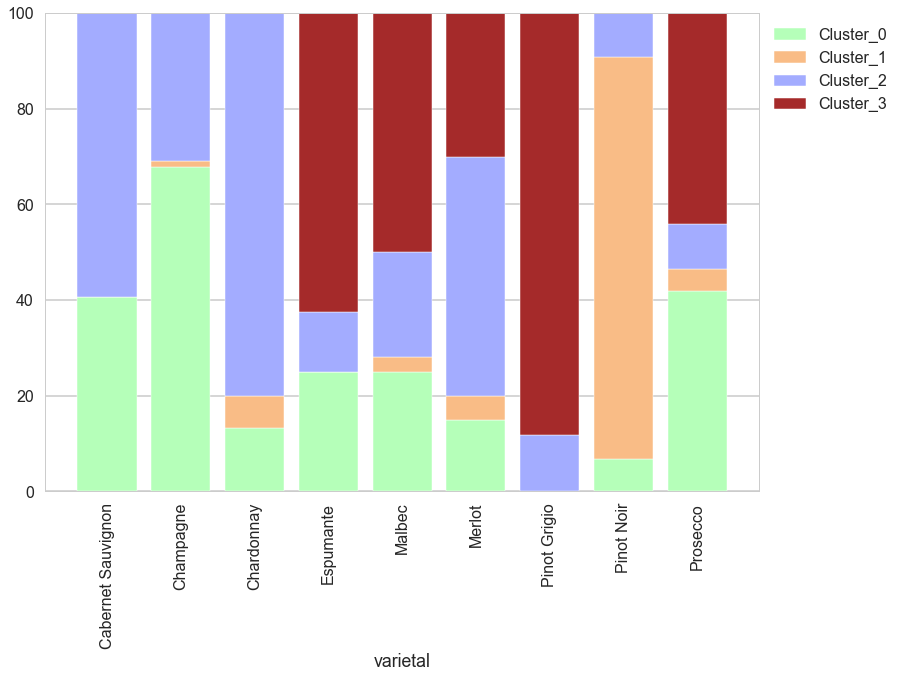

In [446]:
#Checking the distribution of each cluster
import matplotlib.pyplot as plt
def cluspcntplt(var):
    df_var=df_customer0[[var, 'labels']]
    df_var=df_var.sort_values(by='labels').reset_index()
    df_var=df_customer0[[var, 'labels']]
    dflbs=df_var.groupby('labels')
    
    dflbs_0=dflbs.get_group(0)
    #print(dflbs_0)
    #print('GROUP 0: Distribution of ' + var)
    #print(dflbs_0.groupby(var).count())
    
    dflbs_1=dflbs.get_group(1)
    #print(dflbs_1)
    #print('GROUP 1: Distribution of ' + var)
    #print(dflbs_1.groupby(var).count())
    
    dflbs_2=dflbs.get_group(2)
    #print('GROUP 2: Distribution of ' + var)
    #print(dflbs_2.groupby(var).count())
    
    dflbs_3=dflbs.get_group(3)
    #print('GROUP 3: Distribution of ' + var)
    #print(dflbs_3.groupby(var).count())
    
    #Making one dataframe with all the items and cluster labels
    df_all = dflbs_0.append([dflbs_1,dflbs_2,dflbs_3], ignore_index=True)
    
    #Grouping it by items to get the total number for each item
    df_pcnt_all = df_all.groupby(var).count()

    df_pcnt_all['percentage_0']= (dflbs_0.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all['percentage_1']= (dflbs_1.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all['percentage_2']= (dflbs_2.groupby(var).count()/df_all.groupby(var).count())*100
    df_pcnt_all['percentage_3']= (dflbs_3.groupby(var).count()/df_all.groupby(var).count())*100
    
    df_pcnt_all= df_pcnt_all.rename(columns= {'labels' : 'Total_count'})
    
    df_pcnt_all= df_pcnt_all.reset_index()
    
    df_pcnt_all= df_pcnt_all.fillna(0)
    #print('Percentage distribution of ' + var)
    #print(df_pcnt_all)
    
    #plot staggered bar plot
    barWidth = 0.85
    r = list(range(df_pcnt_all[var].count()))
    
    names = df_pcnt_all[var]
    plt.bar(r, df_pcnt_all['percentage_0'] , color='#b5ffb9', edgecolor='white', label='Cluster_0')
    plt.bar(r, df_pcnt_all['percentage_1'], bottom=df_pcnt_all['percentage_0'], color='#f9bc86', edgecolor='white', label='Cluster_1')
    plt.bar(r, df_pcnt_all['percentage_2'], bottom=[i+j for i,j in zip(df_pcnt_all['percentage_0'], df_pcnt_all['percentage_1'])], color='#a3acff', edgecolor='white',  label='Cluster_2')
    plt.bar(r, df_pcnt_all['percentage_3'], bottom=[i+j+k for i,j,k in zip(df_pcnt_all['percentage_0'], df_pcnt_all['percentage_1'],df_pcnt_all['percentage_2'])], color='#A52A2A', edgecolor='white',  label='Cluster_3')
    
    # Custom x axis
    plt.xticks(r, names)
    plt.xlabel(var)
    plt.xticks(rotation=90)
    
    #Put legends 
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.show()
    

cluspcntplt('varietal')


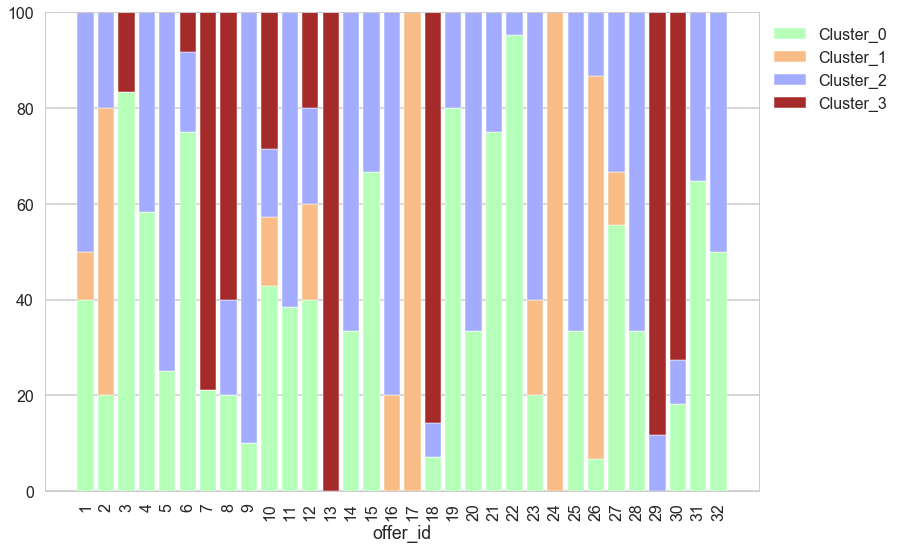

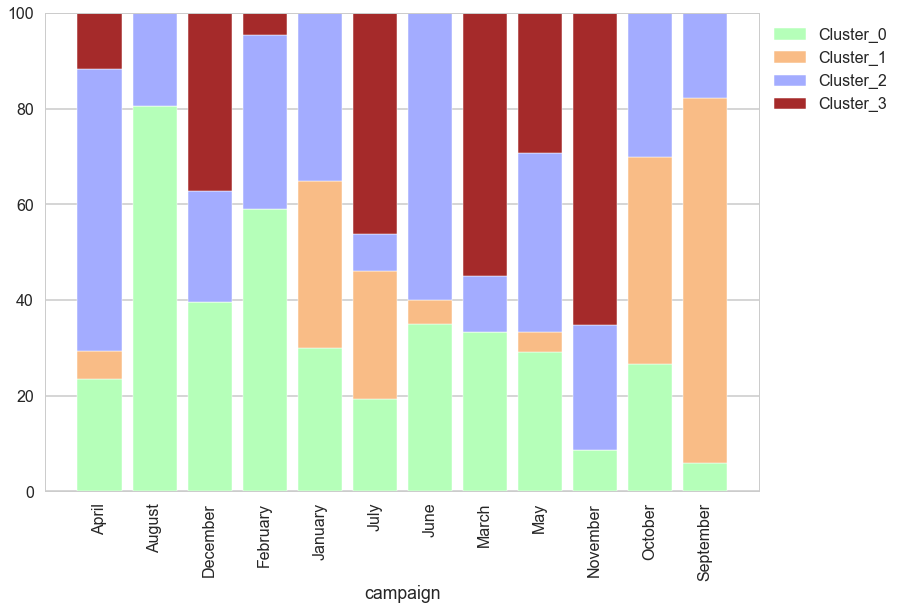

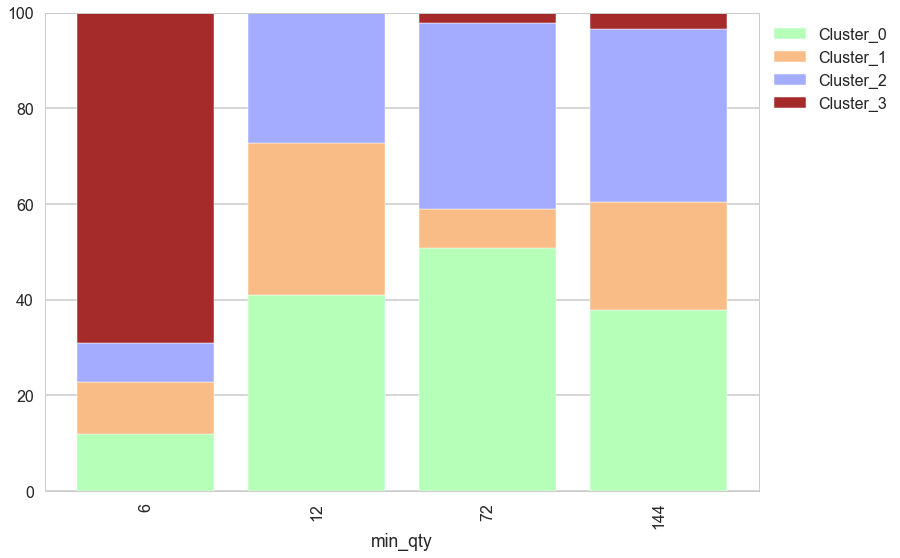

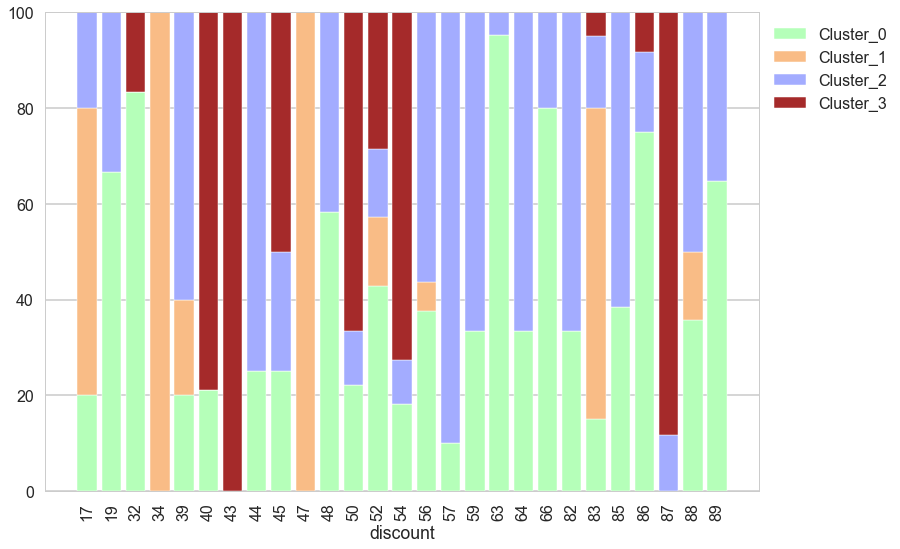

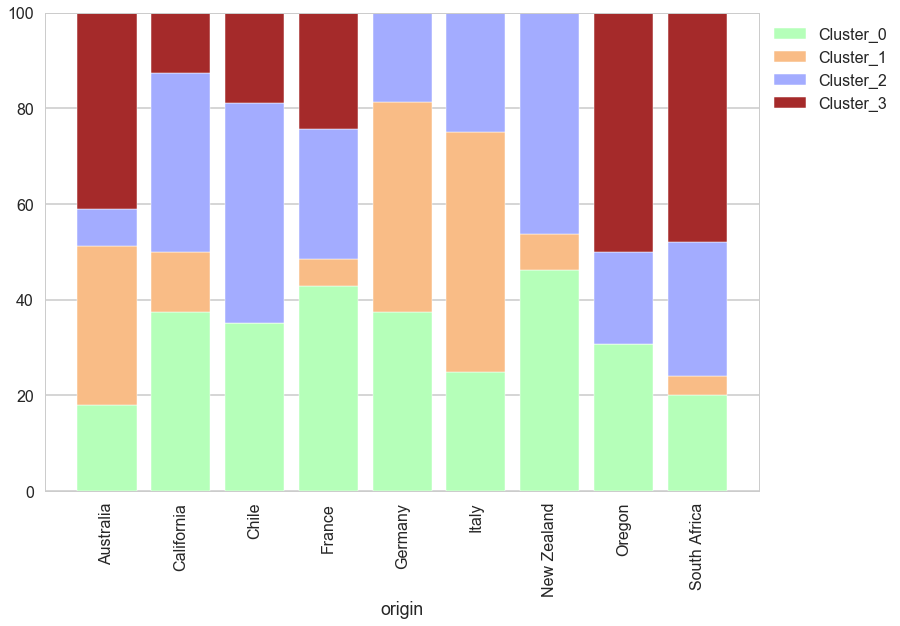

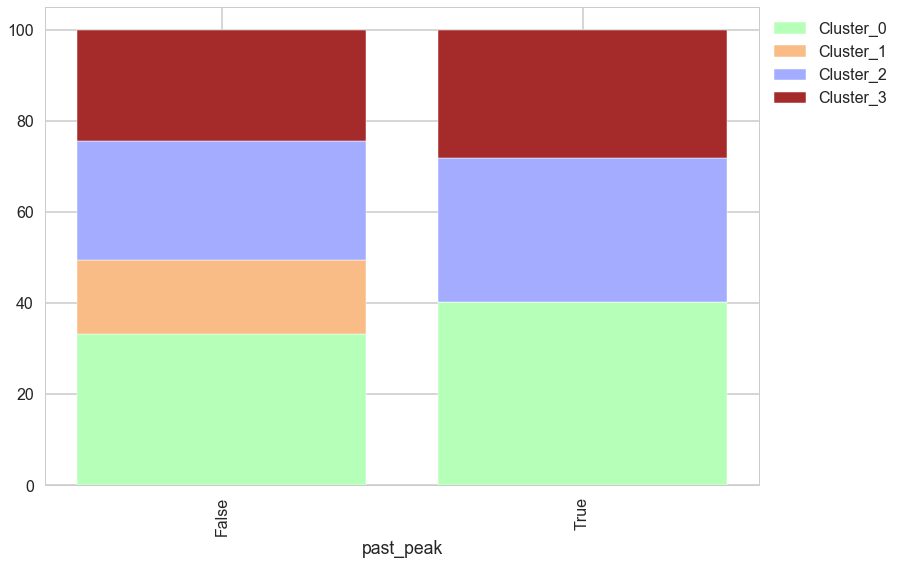

In [447]:
var_list = [ 'offer_id', 'campaign', 'min_qty', 'discount', 'origin', 'past_peak']
for var in var_list:
    cluspcntplt(var)

### Looking at the percentage staggered plots for each item type gives us great insights into preferences of each cluster. 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

[ 0.40555241  0.30446016  0.20026967  0.1653668   0.14865096  0.14200293
  0.13680698  0.12070372  0.1151981   0.10696228  0.09838435  0.09401002
  0.08603449  0.07184171  0.06543861  0.06183019  0.05578045  0.05274121
  0.04681513  0.04349972  0.03861419  0.03589526  0.03421157  0.0320274
  0.02911226  0.02592039  0.02285085  0.02121206  0.01862586  0.01635995
  0.01411925  0.00770111]


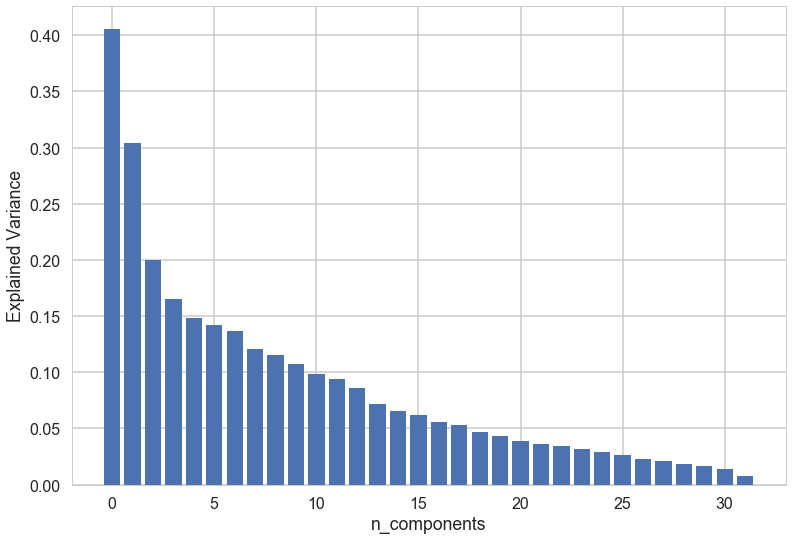

In [457]:
#your turn
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
pca = PCA(random_state=1)
df_pca_comp = df_customer4.copy()
pca.fit(df_pca_comp)
pca_variance = pca.explained_variance_
print(pca_variance)
x_comp = list(range(pca.n_components_))
plt.bar(x_comp,pca_variance )
plt.ylabel('Explained Variance')
plt.xlabel('n_components')

plt.show()



#### Good PCA component choice would be 4.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       0
Allen         -0.287539  0.044715      10
Anderson      -0.392032  1.038391       6
Bailey         0.699477 -0.022542       3
Baker          0.088183 -0.471695       3


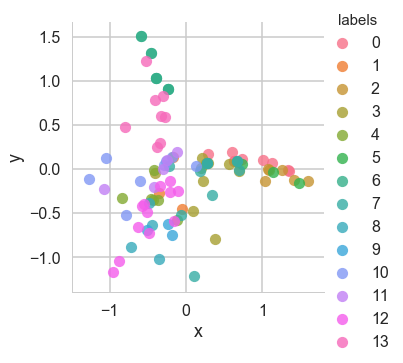

In [466]:
def pcaplt(cls_pca, n_comp, df_cust):
    df= df_cust.copy()
    pca=PCA(n_components= n_comp, random_state=1) #instantiate PCA
    pca.fit(df) #perform PCA
    data_pca = pd.DataFrame(pca.transform(df)) #get 2 components for PCA
    
    #cls_pca = cls(n_clusters=n_clus, random_state=1) #instantiate clustering
    #df['cluster']=cls_pca.fit_predict(matrix) #Perform Clustering on the matrix which is x_cols here
    labels=cls_pca.labels_ #get cluster labels from clustering algorithm to put in pca table
    
    
    data_pca.index = df.index
    data_pca.columns = ['x','y'] #naming two components as x and y
    
    data_pca['labels']= labels #putting labels in the table
    print(data_pca.head())
    
    sns.lmplot(x='x', y='y', hue='labels', data=data_pca, fit_reg=False) #ploting to see the distribution
    
#plot with K=4
from sklearn.cluster import AffinityPropagation
AP= AffinityPropagation()
AP.fit(x_cols)
pcaplt(AP, 2,df_customer4)

                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       0
Allen         -0.287539  0.044715       1
Anderson      -0.392032  1.038391       2
Bailey         0.699477 -0.022542       0
Baker          0.088183 -0.471695       1
offer_id         1    2    3    4    5    6    7    8    9   10   ...      24  \
customer_name                                                     ...           
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   ...     0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   ...     1.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   ...     0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   ...     0.0   

offer_id        25   26   27   28   29   30   31   32  cluster  
customer_name                                                   
Adams   

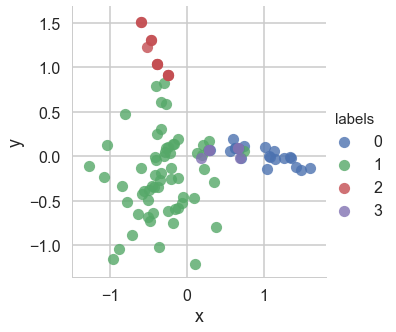

In [459]:
# Your turn
#plot with K=4 and pcs component=2
from sklearn.cluster import SpectralClustering

#plot with K=4 Spectral Clustering
pca(SpectralClustering, 4, 2, x_cols, df_customer4)


                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       1
Allen         -0.287539  0.044715       0
Anderson      -0.392032  1.038391       2
Bailey         0.699477 -0.022542       1
Baker          0.088183 -0.471695       1


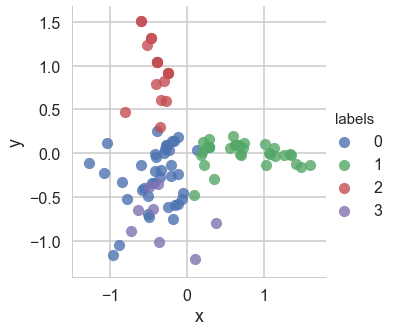

In [467]:
from sklearn.cluster import AgglomerativeClustering

#plot with K=4 Spectral Clustering
AGC=AgglomerativeClustering(n_clusters=4)
AGC.fit(x_cols)
pcaplt(AGC, 2,df_customer4)



                      x         y  labels
customer_name                            
Adams          1.007580  0.108215      -1
Allen         -0.287539  0.044715      -1
Anderson      -0.392032  1.038391       1
Bailey         0.699477 -0.022542       0
Baker          0.088183 -0.471695      -1


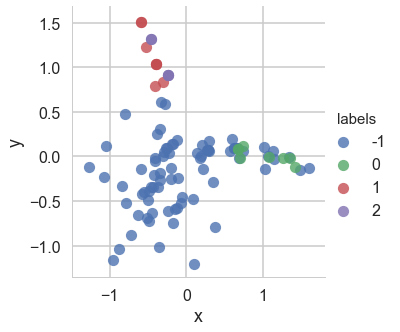

In [478]:
from sklearn.cluster import DBSCAN

#plot with K=4 Spectral Clustering
DBS=DBSCAN(eps=1, min_samples=8)
DBS.fit(x_cols)
pcaplt(DBS, 2,df_customer4)



                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       0
Allen         -0.287539  0.044715       0
Anderson      -0.392032  1.038391       0
Bailey         0.699477 -0.022542       0
Baker          0.088183 -0.471695       0


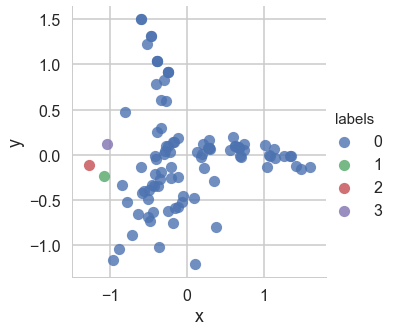

In [479]:
from sklearn.cluster import MeanShift

#plot with K=4 Spectral Clustering
MS=MeanShift()
MS.fit(x_cols)
pcaplt(MS, 2,df_customer4)

                      x         y  labels
customer_name                            
Adams          1.007580  0.108215       3
Allen         -0.287539  0.044715       1
Anderson      -0.392032  1.038391       2
Bailey         0.699477 -0.022542       3
Baker          0.088183 -0.471695       1


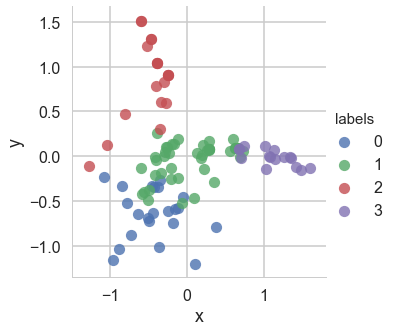

In [485]:
from sklearn.cluster import MiniBatchKMeans

#plot with K=4 Spectral Clustering
MBKM=MiniBatchKMeans(n_clusters=4, random_state=5)
MBKM.fit(x_cols)
pcaplt(MBKM, 2,df_customer4)